# Blade (rectangular) crack under uniform tension - displacement discontinuity solution

3D Elastic problem - we use triangular elements. 

For a rectangukar crack $(-L,L)\times (-h,h) $ of sufficient half-length L (along $x_1$) compared to its half-height h (along $x_2$), we expect a local plane-strain relation at the middle cross-section.

The analytical solution for the  crack displacement discontinuity for a plane-strain - uniformly loaded crack under tension : $t_1=t_2=0,\,t_3 = \sigma $

$\Delta u_{x_3} (x_2,x_1=0)=\frac{4 \sigma}{  E^\prime} \sqrt{h^2-x_2^2} =\frac{2 (1-\nu) \sigma}{ G} \sqrt{h^2-x_2^2}  $ 

$\Delta u_{x_1} (x_2,x_1=0)= \Delta u_{x_2} (x_2,x_1=0)= 0 $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# %% importing BigWham 

from bigwham4py import BEMatrix

# load the analytical solution 
sys.path.append(os.path.join(os.getcwd(), '../../'))
from solutions.penny_shaped_crack_uniform import width


In [2]:
#Elastic properties
G=1.
nu=0.15

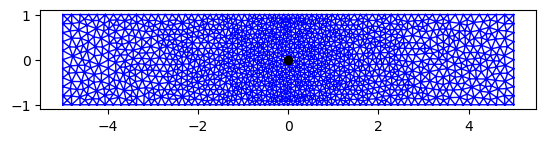

In [31]:
#  Unstructed mesh of a rectangle - with aspect ratio 1 / 5
import pygmsh
L=5
h=1
res_1 = 0.2
res_c = 0.1

with pygmsh.geo.Geometry() as geom:
    pt1 = geom.add_point([-L, -h,0.0], res_1)
    pt2 = geom.add_point([0.,-h,0.0], res_c)
    pt3 = geom.add_point([L,-h,0.0], res_1)
    pt4 = geom.add_point([L,h,0.0], res_1)
    pt5 = geom.add_point([0.,h,0.0], res_c)
    pt6 = geom.add_point([-L,h,0.0], res_1)

    l12 = geom.add_line(pt1, pt2)
    l23 = geom.add_line(pt2, pt3)
    l34 = geom.add_line(pt3, pt4)
    l45 = geom.add_line(pt4, pt5)
    l56 = geom.add_line(pt5, pt6)
    l61 = geom.add_line(pt6, pt1)
    
    l25 = geom.add_line(pt2, pt5)

    loop1 = geom.add_curve_loop([l12,l23,l34,l45,l56,l61])
    
    geom.add_plane_surface(loop1)

    geom.synchronize()
    g_mesh = geom.generate_mesh(order=1,algorithm=2)

   
g_mesh.points.shape[1]
coor=g_mesh.points
conn=g_mesh.cells_dict['triangle']
# swap_c = conn.copy()
# swap_c[:,0]=conn[:,2]
# swap_c[:,2]=conn[:,0]
# conn=swap_c

## plotting the unstructured mesh
import matplotlib
triang=matplotlib.tri.Triangulation(coor[:,0], coor[:,1], triangles=conn, mask=None)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'b-', lw=1)
ax1.plot(0.,0.,'ko')
plt.show()


In [32]:
kernel = "3DT0-H"
elas_prop = np.array([2*G*(1+nu), nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-5
Eh = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=16)


NUM OF AVAILABLE OMP THREADS: 16
BigWham using 16 OpenMP threads
 Now setting things for kernel ... 3DT0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.001843
 binary cluster tree depth =7
 Number of blocks =841
 Number of full blocks =409
 Number of low rank blocks =432
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 409 
Loop on low rank blocks construction
N low rank blocks 432
dof_dimension: 3
Creation of hmat done in 2.08317
Compression ratio - 0.322623
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.322623, eps_aca = 1e-05, eta = 3
Hierarchical matrix  construction time = :  2.08323
BigWham constructed Hmat of size (2684 x 3) X (2684 x 3)
------

number of blocks 841


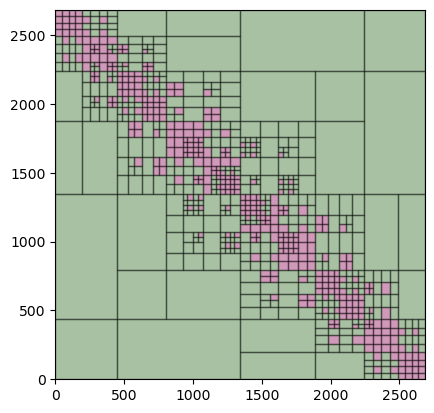

In [33]:
Eh.plotPattern()

In [34]:
# uniform tensile loading o f unit intensity
f = np.zeros(Eh.shape_[0])
f[2::3]=1

# iterative solver solution 
from scipy.sparse.linalg import gmres

jac_ilu= Eh.H_ILU_prec(drop_tol=1.e-1,fill_factor=1) # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(Eh,f,M=jac_ilu,rtol=1e-6)[0]
d_global=Eh.convert_to_global(d)

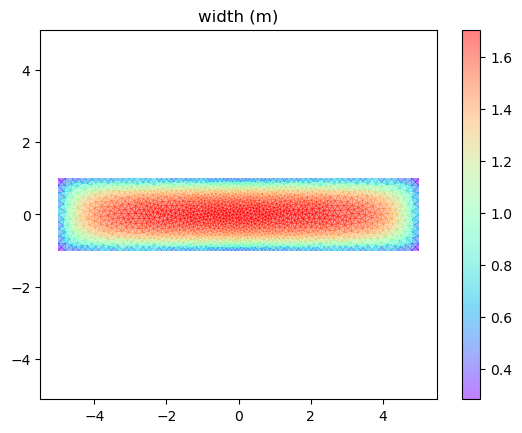

In [35]:
fig1, ax1 = plt.subplots()
tri=ax1.tripcolor(triang, d_global[2::3],cmap = plt.cm.rainbow, 
                    alpha = 0.5)
ax1.axis('equal')
plt.colorbar(tri) 
plt.title('width (m)')
plt.show()


We compare the width profile along $x_2$ in the center part of the blade $|x_1|<2$, where it should be following the 2D griffith uniform tension solution.

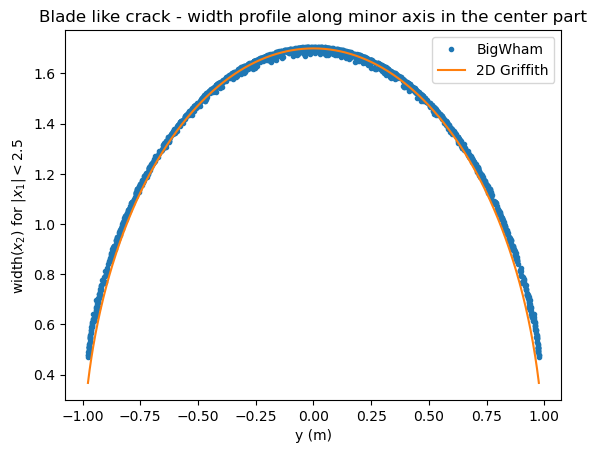

In [52]:
# collocation points - to compute analytical solutionm for width and then estimate stress & displacement at observations points
colpts=Eh.getCollocationPoints()
y_col = np.sort(colpts[:,1])
# Crack opening displacement discontinuity from analytical solution 
w = (2*(1-nu)/(G))*np.sqrt(h**2-y_col**2)   
w_ns = (2*(1-nu)/(G))*np.sqrt(h**2-colpts[:,1]**2)   

middle=np.argwhere(np.abs(colpts[:,0])<2.5).flatten()

plt.plot(colpts[:,1][middle],d_global[2::3][middle],'.')

plt.plot(y_col,w)
plt.xlabel('y (m)')
plt.ylabel('width($x_2$) for $|x_1|<2.5$ ')
plt.legend(['BigWham','2D Griffith'])
plt.title('Blade like crack - width profile along minor axis in the center part')
abs_err =np.abs(w_ns-d_global[2::3]) 
rel_err =np.abs(w_ns-d_global[2::3])/w

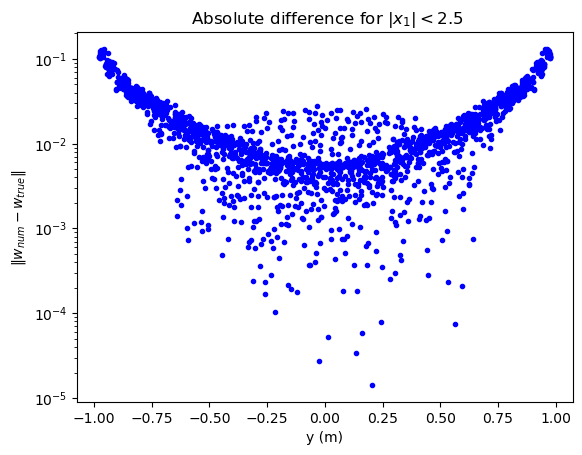

In [54]:
plt.plot(colpts[:,1][middle],abs_err[middle],'.b')
plt.xlabel('y (m)')
plt.ylabel('$\| w_{num}-w_{true} \|$ ')
plt.title(' Absolute difference for $|x_1|<2.5$')

plt.yscale("log")

In [56]:
# L2 norm of the error     $\|| w_{true}(r_i)-w_{num}(r_i)\||_2  / \||  w_{true}(r_i)\|
np.linalg.norm(abs_err[middle])/np.linalg.norm(w_ns[middle])

0.026047839450928544